In [1]:
import random
import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from tqdm import tqdm
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


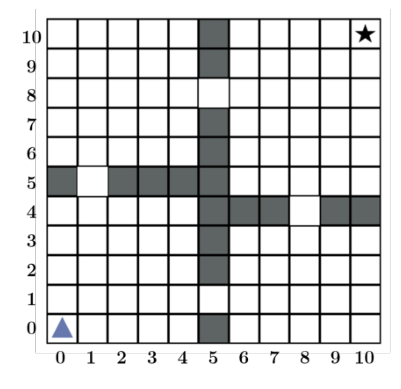

In [3]:
# Board image
img_path1 = '/content/drive/MyDrive/Colab/NU/CIVE5180/board.png'
img = Image.open(img_path1)

plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
# FOUR ROOM ENVIRONMENT

class FourRooms(object):

    def __init__(self):
        '''
        Define the environment as a 2-D array for easy state space reference and visualization.
        Define the state space, action space, start state and goal.
        '''

        # 0 represents an empty cell; 1 represents a wall cell
        self.four_room_space = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Find the indices of all empty cells in the  array (where the cell value is equal to zero).
        empty_cells = np.where(self.four_room_space == 0)

        # State space
        '''
        Create a state space list by iterating through the empty cell indices.
        The state_space will contain [column, adjusted_row] pairs (re-projection),
        where 'adjusted_row' is calculated as (10 - row) to convert the row index.
        N.B. 2-D NumPy origin is top-left. FourRooms origin is bottom-left```
        self.state_space = [[col, 10 - row] for row, col in zip(empty_cells[0], empty_cells[1])]
        '''
        self.state_space = [[col, 10 - row] for row, col in zip(empty_cells[0], empty_cells[1])]


        # Action space
        '''
        Action space defining possible moves as vectors.
        Each action corresponds to a change in the agent's position.
        '''
        self.action_space = {
            'LEFT': np.array([-1, 0]),    # Move left (decrease column index)
            'RIGHT': np.array([1, 0]),    # Move right (increase column index)
            'DOWN': np.array([0, -1]),    # Move down (decrease row index)
            'UP': np.array([0, 1])        # Move up (increase row index)
        }

        # Start state
        self.start_state = [0, 0]         # bottom-left corner

        # Goal state
        self.goal_state = [10, 10]        # top-right corner


    def reset(self):
        '''
        Reset the agent's state to the start state [0, 0].
        Returns both the start state and the initial reward.
        '''
        state = self.start_state    # Reset the agent to the start position, [0, 0].
        reward = 0                  # Initial reward is set to 0.
        return state, reward


    def step(self, state, action):
        '''
        Args:
            state (list): The current state of the agent as [x, y] coordinates. e.g., [2, 7].
            action (str): The action the agent is taking, one of ['UP', 'DOWN', 'LEFT', 'RIGHT'].

        Returns:
            next_state (list): The new state after the action and noise are applied.
            reward (int): The reward, which is 1 if the agent reaches the goal, otherwise 0.
        '''

        if state == [10, 10]:
            # If agent is at the goal, reset to start state and give reward of 1
            return [0, 0], 1

        # Define the probabilities for the action noise
        noise_prob = np.random.rand()

        # Apply the main action with 80% probability
        if noise_prob < 0.8:
            next_state = self.take_action(state, action)

        # Apply perpendicular actions with 10% probability each
        elif noise_prob < 0.9:
            if action == 'UP' or action == 'DOWN':
                next_state = self.take_action(state, 'LEFT' if action == 'UP' else 'RIGHT')
            else:
                next_state = self.take_action(state, 'UP' if action == 'RIGHT' else 'DOWN')
        else:
            if action == 'UP' or action == 'DOWN':
                next_state = self.take_action(state, 'RIGHT' if action == 'UP' else 'LEFT')
            else:
                next_state = self.take_action(state, 'DOWN' if action == 'RIGHT' else 'UP')

        # If the next state is invalid (into a wall or out of bounds), stay in the current state
        if next_state not in self.state_space:
            next_state = state

        # Reward is 1 if agent reaches the goal, otherwise 0
        reward = 1 if next_state == [10, 10] else 0

        return next_state, reward


    def take_action(self, state, action):
        '''
        Args:
            state (list): The current state of the agent as [x, y] coordinates. e.g., [2, 7].
            action (str): The action the agent is taking, one of ['UP', 'DOWN', 'LEFT', 'RIGHT'].

        Returns:
            next_state (list): The new position of the agent after applying the action.
                               If the action would take the agent into a wall or out of bounds,
                               the agent stays in the current state.
        '''

        # Convert the state list to a NumPy array for easier mathematical operations.
        state = np.array(state)

        # Calculate the next state by adding the action vector to the current state.
        next_state = state + self.action_space[action]

        # Check if the computed next state is valid by verifying if it exists in self.state_space.
        # If the next state is valid (i.e., in the state_space), return it as a list.
        # Otherwise, return the current state (i.e., no movement).
        return next_state.tolist() if next_state.tolist() in self.state_space else state.tolist()

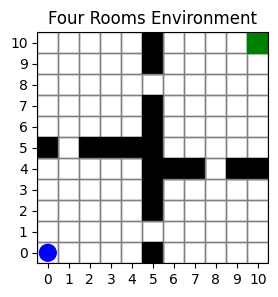

Current state: [0, 0]
Enter action (UP, DOWN, LEFT, RIGHT): up


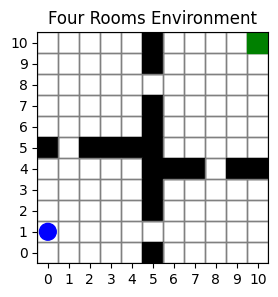

Current state: [0, 1]
Enter action (UP, DOWN, LEFT, RIGHT): up


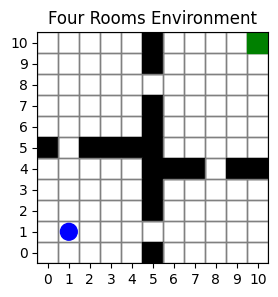

Current state: [1, 1]
Enter action (UP, DOWN, LEFT, RIGHT): up


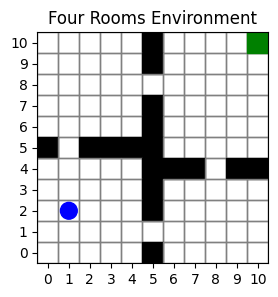

Current state: [1, 2]
Enter action (UP, DOWN, LEFT, RIGHT): up


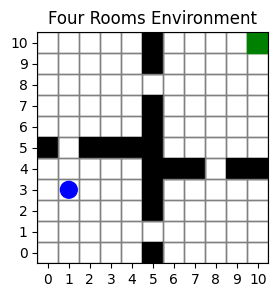

Current state: [1, 3]
Enter action (UP, DOWN, LEFT, RIGHT): up


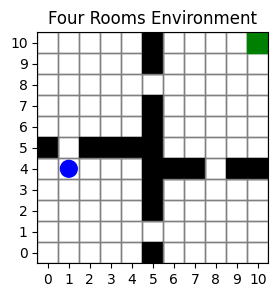

Current state: [1, 4]
Enter action (UP, DOWN, LEFT, RIGHT): up


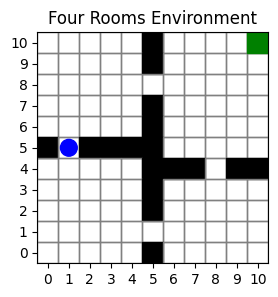

Current state: [1, 5]
Enter action (UP, DOWN, LEFT, RIGHT): up


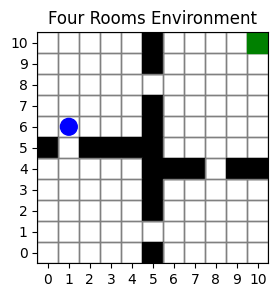

Current state: [1, 6]
Enter action (UP, DOWN, LEFT, RIGHT): right


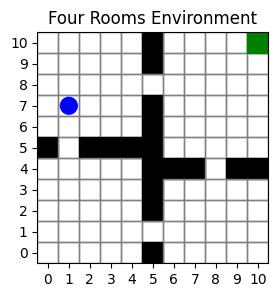

Current state: [1, 7]
Enter action (UP, DOWN, LEFT, RIGHT): right


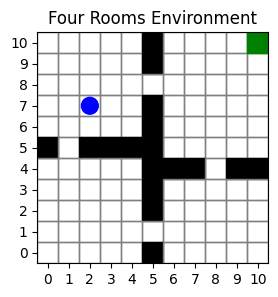

Current state: [2, 7]
Enter action (UP, DOWN, LEFT, RIGHT): right


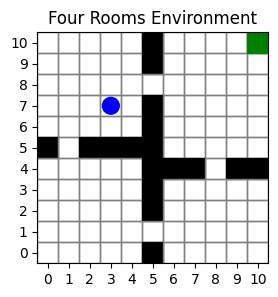

Current state: [3, 7]
Enter action (UP, DOWN, LEFT, RIGHT): right


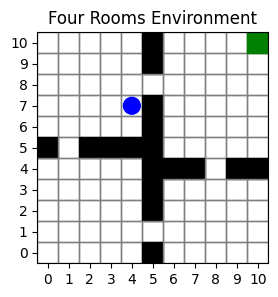

Current state: [4, 7]
Enter action (UP, DOWN, LEFT, RIGHT): right


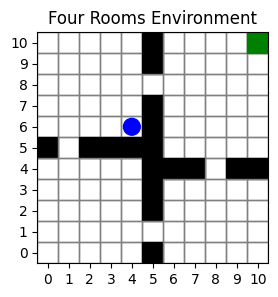

Current state: [4, 6]
Enter action (UP, DOWN, LEFT, RIGHT): up


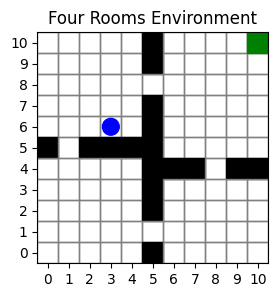

Current state: [3, 6]
Enter action (UP, DOWN, LEFT, RIGHT): up


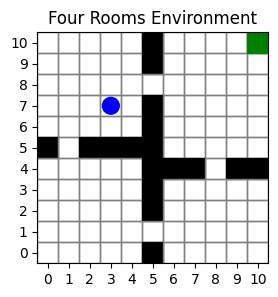

Current state: [3, 7]
Enter action (UP, DOWN, LEFT, RIGHT): right


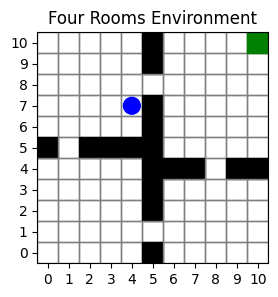

Current state: [4, 7]
Enter action (UP, DOWN, LEFT, RIGHT): up


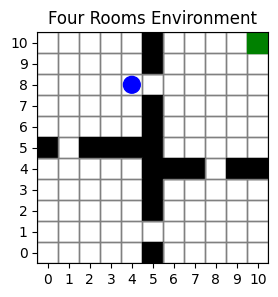

Current state: [4, 8]
Enter action (UP, DOWN, LEFT, RIGHT): right


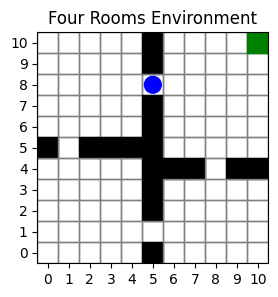

Current state: [5, 8]
Enter action (UP, DOWN, LEFT, RIGHT): right


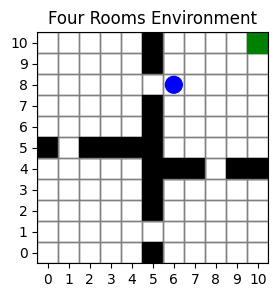

Current state: [6, 8]
Enter action (UP, DOWN, LEFT, RIGHT): right


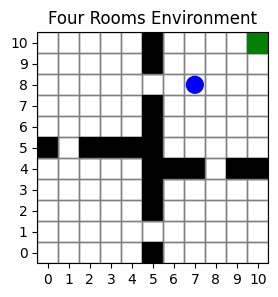

Current state: [7, 8]
Enter action (UP, DOWN, LEFT, RIGHT): right


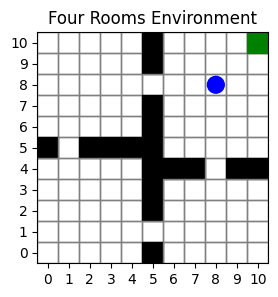

Current state: [8, 8]
Enter action (UP, DOWN, LEFT, RIGHT): right


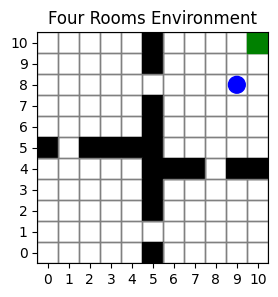

Current state: [9, 8]
Enter action (UP, DOWN, LEFT, RIGHT): up


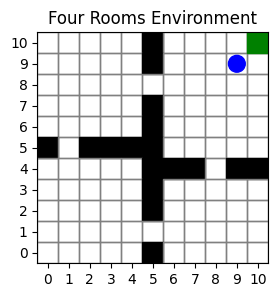

Current state: [9, 9]
Enter action (UP, DOWN, LEFT, RIGHT): up


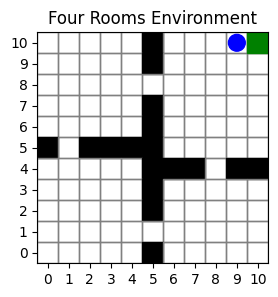

Current state: [9, 10]
Enter action (UP, DOWN, LEFT, RIGHT): right


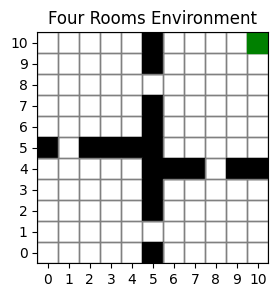

Goal reached! Resetting the agent to the start state.


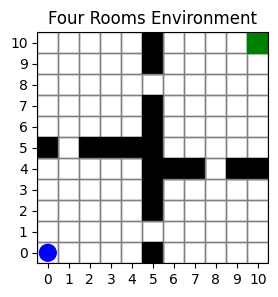

Current state: [0, 0]
Enter action (UP, DOWN, LEFT, RIGHT): up


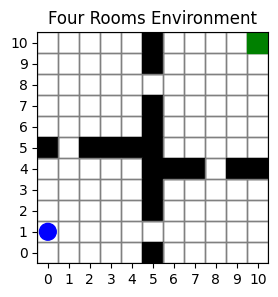

Current state: [0, 1]
Enter action (UP, DOWN, LEFT, RIGHT): right


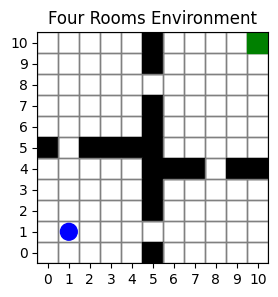

Current state: [1, 1]
Enter action (UP, DOWN, LEFT, RIGHT): up


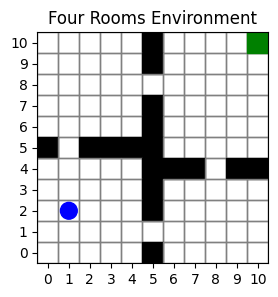

Current state: [1, 2]


In [ ]:
# MANUAL POLICY

# PLOT FUNCTION FOR VISUALIZATION
def plot_grid(env, agent_pos):
    fig, ax = plt.subplots(figsize=(3, 3))

    # Draw the environment (walls and empty cells)
    for i in range(env.four_room_space.shape[0]):
        for j in range(env.four_room_space.shape[1]):
            if env.four_room_space[i, j] == 1:
                ax.add_patch(patches.Rectangle((j, 10 - i), 1, 1, color='black'))
            else:
                ax.add_patch(patches.Rectangle((j, 10 - i), 1, 1, edgecolor='gray', fill=None))

    # Draw the agent
    ax.add_patch(patches.Circle((agent_pos[0] + 0.5, agent_pos[1] + 0.5), 0.4, color='blue', label='Agent'))

    # Draw the goal
    ax.add_patch(patches.Rectangle((10, 10), 1, 1, color='green', label='Goal'))

    # Set limits, labels, and title
    plt.xlim(0, 11)
    plt.ylim(0, 11)

    # Adjust axis ticks to be centered in the cells
    ax.set_xticks(np.arange(0.5, 11.5, 1))  # Set x-ticks at the center of each grid cell
    ax.set_yticks(np.arange(0.5, 11.5, 1))  # Set y-ticks at the center of each grid cell
    ax.set_xticklabels(np.arange(0, 11, 1))  # Label x-ticks as 0, 1, 2, ..., 10
    ax.set_yticklabels(np.arange(0, 11, 1))  # Label y-ticks as 0, 1, 2, ..., 10

    # Disable all grid lines
    ax.grid(False)  # Disable grid lines entirely

    # Set the aspect ratio of the plot to be equal
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title("Four Rooms Environment")
    plt.show()


# SIMULATOR FUNCTION
def run_simulator(env, num_steps):
    state, _ = env.reset()  # Reset environment
    plot_grid(env, state)   # Plot initial state

    for step in range(num_steps):
        action = manual_policy(state)  # Use manual policy to get the action

        # Take a step
        next_state, reward = env.step(state, action)

        # Plot updated state
        plot_grid(env, next_state)

        # Check if agent reached goal
        if reward == 1:
            print("Goal reached! Resetting the agent to the start state.")
            state, _ = env.reset()
            plot_grid(env, state)
        else:
            state = next_state

# MANUAL POLICY FUNCTION
def manual_policy(state):
    '''
    Prompts the user for an action based on the current state of the agent.

    Args:
        state (list): Current state of the agent as [x, y] coordinates.

    Returns:
        action (str): The action chosen by the user, one of ['UP', 'DOWN', 'LEFT', 'RIGHT'].
    '''
    print(f'Current state: {state}')  # Display the current state to the user
    action = input("Enter action (UP, DOWN, LEFT, RIGHT): ").upper()

    # Validate the input to ensure it's one of the allowed actions
    while action not in ['UP', 'DOWN', 'LEFT', 'RIGHT']:
        print("Invalid action! Please enter one of: 'UP', 'DOWN', 'LEFT', 'RIGHT'.")
        action = input("Enter action (UP, DOWN, LEFT, RIGHT): ").upper()

    return action

# MAIN
if __name__ == "__main__":
    random.seed(42)              # For reproducibility
    np.random.seed(42)

    env = FourRooms()            # Initialize environment
    state, reward = env.reset()  # Reset the environment before interaction
    num_steps = 100              # Num. of time steps for which the agent will interact with the env.
    run_simulator(env, num_steps)

# Agent's interaction with the environment
for time in range(num_steps):
    # Get the action from the user based on the current state
    action = manual_policy(state)

    # Call the step function to get the next state and reward from the environment
    next_state, reward = env.step(state, action)

    # Print the interaction details
    print(f'Step = {time}, state = {state}, action = {action}, ', end='')
    print(f'next state = {next_state}, reward = {reward}')

    # Reset if agent reaches the goal state
    if reward == 1:
        print('Goal reached! Resetting the agent to the start state!')
        state, reward = env.reset()  # Reset to the start state
    else:
        state = next_state           # Update the current state for the next iteration